# Ну что ж, давайте обучать #

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('ticks')

In [2]:
train = pd.read_excel('semifinal_data/train.xlsx')
test = pd.read_excel('semifinal_data/test.xlsx')
descr = pd.read_excel('semifinal_data/description.xlsx')

## Preprocessing & feature engineering ##

In [3]:
train_idx = train.index
data = pd.concat([train, test], sort=False)
data.shape

(8618, 52)

Отбросим сильно коррелирующие признаки (смотри ноутбук с EDA).

In [4]:
data.drop(['Vit_D_µg', 'Vit_A_RAE', 'Folate_Tot_(µg)'], axis=1, inplace=True)

Добавим признак "число NaNов в строке", заполним NaNы в числовых признаках медианами.

In [5]:
data['Energ_Kcal'].fillna(-1., inplace=True)
data['NaN_number'] = data.isnull().sum(axis=1)

float_cols = list(set(data.columns) - {'GmWt_Desc1', 'GmWt_Desc2', 'Shrt_Desc', 'Energ_Kcal'})
for col in float_cols:
    data[col].fillna(data[col].median(), inplace=True)

Нормализуем числовые признаки.

In [6]:
from sklearn.preprocessing import StandardScaler

for col in float_cols:
    data[col] = StandardScaler().fit_transform(data[col].values.reshape(-1, 1))

Строковые признаки пока что отбросим.

In [7]:
str_cols = ['GmWt_Desc1', 'GmWt_Desc2', 'Shrt_Desc']
data.drop(str_cols, axis=1, inplace=True)

Вернемся к трейну и тесту и нормализуем целевую переменную.

In [8]:
from sklearn.preprocessing import StandardScaler

train = data[data['Energ_Kcal'] != -1]
test = data[data['Energ_Kcal'] == -1]
test.drop('Energ_Kcal', axis=1, inplace=True)

scaler = StandardScaler()
scaler.fit(train['Energ_Kcal'].values.reshape(-1, 1))
train['Energ_Kcal'] = scaler.transform(train['Energ_Kcal'].values.reshape(-1, 1))

/home/data_sapiens/Anaconda/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/data_sapiens/Anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


## Попробуем обучить что-нибудь простенькое ##

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train.drop('Energ_Kcal', axis=1), train['Energ_Kcal'], 
                                                   shuffle=True)

Нам понадобится особенная метрика (из-за того, что мы скалировали)

In [10]:
from sklearn.metrics import mean_absolute_error

def metric(y_pred, y_true, dmatrix=True):
    if dmatrix:
        y_true_rescaled = scaler.inverse_transform(y_true.get_label().reshape(-1, 1))
    else:
        y_true_rescaled = scaler.inverse_transform(y_true.reshape(-1, 1))
    y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
    return ('mae', mean_absolute_error(y_true_rescaled, y_pred_rescaled))

In [11]:
from __future__ import print_function
from xgboost import XGBRegressor
from IPython.utils import io

model = XGBRegressor(n_estimators=1200)
with io.capture_output() as captured:
    model.fit(X_train.values, y_train.values, eval_set=[(X_train.values, y_train.values),
              (X_test.values, y_test.values)], eval_metric=metric, verbose=True)

print('MAE на валидационном сете: ', metric(model.predict(X_test.values), y_test.values, False))

MAE на валидационном сете:  ('mae', 5.6481186195654685)


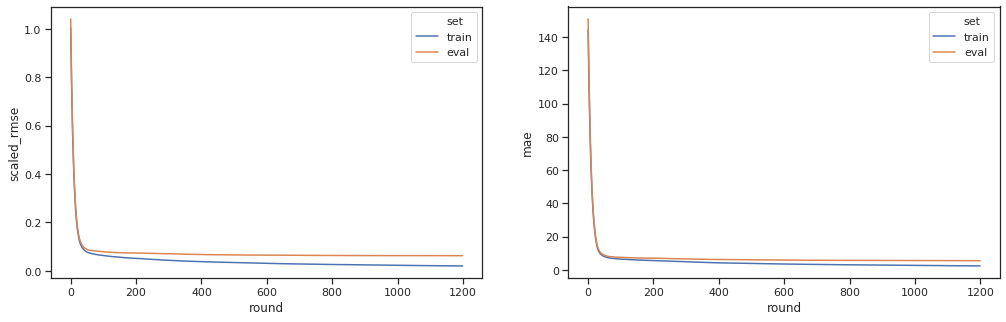

In [12]:
info = captured.stdout.split('\t')[1:]
curve = [[], [], [], []]
for i in range(0, len(info)):
    score = float(info[i].split(':')[1].split('\n')[0])
    curve[i % 4].append(score)

rounds = len(curve[0])

index = np.array([[i, i] for i in range(rounds)]).reshape((2 * rounds,))
np_curve = np.array(curve).T
np_curve[:, [1, 2]] = np_curve[:, [2, 1]]
pd_curve = pd.DataFrame(np_curve.reshape((2 * rounds, 2)), columns=['scaled_rmse', 'mae'])
pd_curve['round'] = index
pd_curve['set'] = np.array([['train', 'eval'] for i in range(rounds)]).reshape((2 * rounds,))

f, axes = plt.subplots(1, 2, figsize=(17, 5))

sns.lineplot(data=pd_curve, x='round', y='scaled_rmse', hue='set', ax=axes[0])
sns.lineplot(data=pd_curve, x='round', y='mae', hue='set', ax=axes[1])

## Предсказание ##

In [13]:
test_pred = model.predict(test.values)
test_pred = scaler.inverse_transform(test_pred.reshape(-1, 1))
answer = pd.Series(test_pred.reshape(-1), name='Pred_kcal')
answer.to_csv('semifinal_files/baseline1.csv', index=False, header=True)